<a href="https://colab.research.google.com/github/vijaynaykodi/deep_learning/blob/main/Fine_Tune_LLM6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



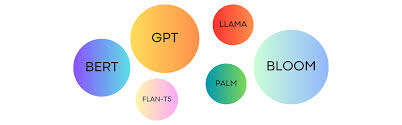

In [225]:
! pip install -U accelerate
! pip install -U transformers
!pip install datasets
!pip install tokenizers
!pip install evaluate
!pip install rouge_score
!pip install sentencepiece
!pip install huggingface_hub

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Jan 16 04:16:49 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P0              28W /  70W |   7917MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
import accelerate
import transformers
import datasets

transformers.__version__, accelerate.__version__

('4.36.2', '0.26.1')

## **Loading the T5 small model and verifying the same.**





In [229]:
import torch
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
from transformers import Seq2SeqTrainingArguments
import accelerate
from transformers import T5Tokenizer, TFT5Model
import evaluate
import numpy as np
from datasets import load_dataset
from transformers import T5Tokenizer, DataCollatorForSeq2Seq
from transformers import T5ForConditionalGeneration, Seq2SeqTrainingArguments, Seq2SeqTrainer

In [233]:
model = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-small")
tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-small")

inputs = tokenizer("how to make cake", return_tensors="pt")
outputs = model.generate(**inputs)
print(tokenizer.batch_decode(outputs, skip_special_tokens=True))

['Using a sanded cake mix, mix the cake mix with the cake']


In [234]:
model = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-small")
tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-small")

inputs = tokenizer("Summarize :"+"The first European to discover Guam was Portuguese navigator Ferdinand Magellan, sailing for the King of Spain, when he sighted the island on March 6, 1521 during his fleet\'s circumnavigation of the globe.:41–42 When Magellan arrived on Guam, he was greeted by hundreds of small outrigger canoes that appeared to be flying over the water, due to their considerable speed. These outrigger canoes were called Proas, and resulted in Magellan naming Guam Islas de las Velas Latinas (Islands of the Lateen sails). Antonio Pigafetta, one of Magellan\'s original 18 the name Island of Sails, but he also writes that the inhabitants entered the ships and stole whatever they could lay their hands on, including the small boat that was fastened to the poop of the flagship.:129 Those people are poor, but ingenious and very thievish, on account of which we called those three islands Islas de los Ladrones (Islands of thieves).", return_tensors="pt")
outputs = model.generate(**inputs)
print(tokenizer.batch_decode(outputs, skip_special_tokens=True))

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


['The first European to discover Guam was the Portuguese navigator Ferdinand Magellan, who ']


In [235]:
model = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-small")
tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-small")

inputs = tokenizer("Translate to French:"+"The first European to discover Guam was Portuguese navigator Ferdinand Magellan, sailing for the King of Spain, when he sighted the island on March 6, 1521 during his fleet\'s circumnavigation of the globe.:41–42 When Magellan arrived on Guam, he was greeted by hundreds of small outrigger canoes that appeared to be flying over the water, due to their considerable speed. These outrigger canoes were called Proas, and resulted in Magellan naming Guam Islas de las Velas Latinas (Islands of the Lateen sails). Antonio Pigafetta, one of Magellan\'s original 18 the name Island of Sails, but he also writes that the inhabitants entered the ships and stole whatever they could lay their hands on, including the small boat that was fastened to the poop of the flagship.:129 Those people are poor, but ingenious and very thievish, on account of which we called those three islands Islas de los Ladrones (Islands of thieves).", return_tensors="pt")
outputs = model.generate(**inputs)
print(tokenizer.batch_decode(outputs, skip_special_tokens=True))

["La première européen d'explorer à Guam a été navigateur portugues"]


## **Printing the Model Layer and their Dimensions.**

In [ ]:
from datasets import load_dataset

squad = load_dataset("squad")

In [ ]:
squad

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 87599
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 10570
    })
})

In [ ]:
squad['train']=squad['train'].select(range(25000))
squad['validation']=squad['validation'].select(range(5000))

In [ ]:
squad

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 25000
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 5000
    })
})

In [ ]:
squad["train"][200]

{'id': '572b4a57be1ee31400cb830d',
 'title': 'Guam',
 'context': 'The first European to discover Guam was Portuguese navigator Ferdinand Magellan, sailing for the King of Spain, when he sighted the island on March 6, 1521 during his fleet\'s circumnavigation of the globe.:41–42 When Magellan arrived on Guam, he was greeted by hundreds of small outrigger canoes that appeared to be flying over the water, due to their considerable speed. These outrigger canoes were called Proas, and resulted in Magellan naming Guam Islas de las Velas Latinas ("Islands of the Lateen sails"). Antonio Pigafetta, one of Magellan\'s original 18 the name "Island of Sails", but he also writes that the inhabitants "entered the ships and stole whatever they could lay their hands on", including "the small boat that was fastened to the poop of the flagship.":129 "Those people are poor, but ingenious and very thievish, on account of which we called those three islands Islas de los Ladrones ("Islands of thieves").":13

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-small")

In [ ]:
def preprocess_function(examples):
    questions = [q.strip() for q in examples["question"]]
    inputs = tokenizer(
        questions,
        examples["context"],
        max_length=384,
        truncation="only_second",
        return_offsets_mapping=True,
        padding="max_length",
    )

    offset_mapping = inputs.pop("offset_mapping")
    answers = examples["answers"]
    start_positions = []
    end_positions = []

    for i, offset in enumerate(offset_mapping):
        answer = answers[i]
        start_char = answer["answer_start"][0]
        end_char = answer["answer_start"][0] + len(answer["text"][0])
        sequence_ids = inputs.sequence_ids(i)

        # Find the start and end of the context
        idx = 0
        while sequence_ids[idx] != 1:
            idx += 1
        context_start = idx
        while sequence_ids[idx] == 1:
            idx += 1
        context_end = idx - 1

        # If the answer is not fully inside the context, label it (0, 0)
        if offset[context_start][0] > end_char or offset[context_end][1] < start_char:
            start_positions.append(0)
            end_positions.append(0)
        else:
            # Otherwise it's the start and end token positions
            idx = context_start
            while idx <= context_end and offset[idx][0] <= start_char:
                idx += 1
            start_positions.append(idx - 1)

            idx = context_end
            while idx >= context_start and offset[idx][1] >= end_char:
                idx -= 1
            end_positions.append(idx + 1)

    inputs["start_positions"] = start_positions
    inputs["end_positions"] = end_positions
    return inputs

In [ ]:
print(squad['train'].column_names)
column_names_list=['id','title','context', 'question', 'answers']

['id', 'title', 'context', 'question', 'answers']


In [ ]:
#squad=squad['train'].shuffle(seed=44).select(range(20000))
tokenized_squad = squad.map(preprocess_function, batched=True, remove_columns=column_names_list)

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

In [ ]:
tokenized_squad

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'start_positions', 'end_positions'],
        num_rows: 25000
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'start_positions', 'end_positions'],
        num_rows: 5000
    })
})

In [ ]:
tokenized_squad_train_df=tokenized_squad_train.to_pandas()
len(tokenized_squad_train_df['input_ids'][200])

384

In [226]:
from transformers import DefaultDataCollator

data_collator = DefaultDataCollator()


In [ ]:
from transformers import AutoModelForQuestionAnswering, TrainingArguments, Trainer
model = AutoModelForQuestionAnswering.from_pretrained("google/flan-t5-small")

Some weights of T5ForQuestionAnswering were not initialized from the model checkpoint at google/flan-t5-small and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
training_args = TrainingArguments(
    output_dir="flan_t5_small_qa_vijay",
    overwrite_output_dir=True,
    do_train=True,
    do_eval=True,
    evaluation_strategy="epoch",
    learning_rate=3e-3,
    per_device_train_batch_size=14,
    per_device_eval_batch_size=14,
    num_train_epochs=3,
    weight_decay=0.01,
    push_to_hub=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_squad['train'],
    eval_dataset=tokenized_squad['validation'],
    tokenizer=tokenizer,
    data_collator=data_collator,
)


In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,2.048400,1.881260
2,1.362500,1.557935
3,0.875600,1.482020


TrainOutput(global_step=5358, training_loss=1.5958163100153975, metrics={'train_runtime': 4207.9853, 'train_samples_per_second': 17.823, 'train_steps_per_second': 1.273, 'total_flos': 7614038361600000.0, 'train_loss': 1.5958163100153975, 'epoch': 3.0})

In [ ]:
trainer.push_to_hub()

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

events.out.tfevents.1705380439.1fcf544d5a31.940.1:   0%|          | 0.00/7.99k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/vijaynaykodi/flan_t5_small_qa_vijay/commit/bf115e292d085d10b87551d8813722929b2e52dd', commit_message='End of training', commit_description='', oid='bf115e292d085d10b87551d8813722929b2e52dd', pr_url=None, pr_revision=None, pr_num=None)

# **Question Answering**

In [ ]:
question = "How many programming languages does BLOOM support?"
context = "BLOOM has 176 billion parameters and can generate text in 46 languages natural languages and 13 programming languages."

In [ ]:
from transformers import pipeline

question_answerer = pipeline("question-answering", model="flan_t5_small_qa_vijay")
question_answerer(question=question, context=context)

{'score': 0.31226208806037903, 'start': 92, 'end': 95, 'answer': ' 13'}

In [ ]:
question = "what is Ajay fond of?"
context = "Ajay like vegetables and farming and he lives in Vikarabad"

In [ ]:
from transformers import pipeline

question_answerer = pipeline("question-answering", model="vijaynaykodi/flan_t5_small_qa_vijay")
question_answerer(question=question, context=context)

{'score': 0.731609582901001,
 'start': 9,
 'end': 32,
 'answer': ' vegetables and farming'}

# **Evaluation**

In [ ]:
def preprocess_validation_examples(examples):
    questions = [q.strip() for q in examples["question"]]
    inputs = tokenizer(
        questions,
        examples["context"],
        max_length=max_length,
        truncation="only_second",
        stride=stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    sample_map = inputs.pop("overflow_to_sample_mapping")
    example_ids = []

    for i in range(len(inputs["input_ids"])):
        sample_idx = sample_map[i]
        example_ids.append(examples["id"][sample_idx])

        sequence_ids = inputs.sequence_ids(i)
        offset = inputs["offset_mapping"][i]
        inputs["offset_mapping"][i] = [
            o if sequence_ids[k] == 1 else None for k, o in enumerate(offset)
        ]

    inputs["example_id"] = example_ids
    return inputs

In [ ]:
squad

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 25000
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 5000
    })
})

In [ ]:
max_length = 384
stride = 128
validation_dataset = squad["validation"].map(
    preprocess_validation_examples,
    batched=True,
    remove_columns=squad["validation"].column_names,
)
len(squad["validation"]), len(validation_dataset)

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

(5000, 5227)

In [ ]:
small_eval_set = squad["validation"].select(range(100))
trained_checkpoint = "vijaynaykodi/flan_t5_small_qa_vijay"

tokenizer = AutoTokenizer.from_pretrained(trained_checkpoint)
eval_set = small_eval_set.map(
    preprocess_validation_examples,
    batched=True,
    remove_columns=squad["validation"].column_names,
)

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(trained_checkpoint)

In [ ]:
import torch
from transformers import AutoModelForQuestionAnswering

eval_set_for_model = eval_set.remove_columns(["example_id", "offset_mapping"])
eval_set_for_model.set_format("torch")

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
batch = {k: eval_set_for_model[k].to(device) for k in eval_set_for_model.column_names}
trained_model = AutoModelForQuestionAnswering.from_pretrained(trained_checkpoint).to(
    device
)

with torch.no_grad():
    outputs = trained_model(**batch)

In [ ]:
start_logits = outputs.start_logits.cpu().numpy()
end_logits = outputs.end_logits.cpu().numpy()

In [ ]:
import collections

example_to_features = collections.defaultdict(list)
for idx, feature in enumerate(eval_set):
    example_to_features[feature["example_id"]].append(idx)

In [ ]:
import numpy as np

n_best = 20
max_answer_length = 30
predicted_answers = []

for example in small_eval_set:
    example_id = example["id"]
    context = example["context"]
    answers = []

    for feature_index in example_to_features[example_id]:
        start_logit = start_logits[feature_index]
        end_logit = end_logits[feature_index]
        offsets = eval_set["offset_mapping"][feature_index]

        start_indexes = np.argsort(start_logit)[-1 : -n_best - 1 : -1].tolist()
        end_indexes = np.argsort(end_logit)[-1 : -n_best - 1 : -1].tolist()
        for start_index in start_indexes:
            for end_index in end_indexes:
                # Skip answers that are not fully in the context
                if offsets[start_index] is None or offsets[end_index] is None:
                    continue
                # Skip answers with a length that is either < 0 or > max_answer_length.
                if (
                    end_index < start_index
                    or end_index - start_index + 1 > max_answer_length
                ):
                    continue

                answers.append(
                    {
                        "text": context[offsets[start_index][0] : offsets[end_index][1]],
                        "logit_score": start_logit[start_index] + end_logit[end_index],
                    }
                )

    best_answer = max(answers, key=lambda x: x["logit_score"])
    predicted_answers.append({"id": example_id, "prediction_text": best_answer["text"]})

In [ ]:
import evaluate

metric = evaluate.load("squad")

In [ ]:
 theoretical_answers = [
    {"id": ex["id"], "answers": ex["answers"]} for ex in small_eval_set
]

In [ ]:
print(predicted_answers[10])
print(theoretical_answers[10])

{'id': '56bea9923aeaaa14008c91bb', 'prediction_text': ' February 7, 2016,'}
{'id': '56bea9923aeaaa14008c91bb', 'answers': {'text': ['February 7, 2016', 'February 7', 'February 7, 2016'], 'answer_start': [334, 334, 334]}}


In [ ]:
metric.compute(predictions=predicted_answers, references=theoretical_answers)

{'exact_match': 72.0, 'f1': 80.8}

In [227]:
from tqdm.auto import tqdm


def compute_metrics(start_logits, end_logits, features, examples):
    example_to_features = collections.defaultdict(list)
    for idx, feature in enumerate(features):
        example_to_features[feature["example_id"]].append(idx)

    predicted_answers = []
    for example in tqdm(examples):
        example_id = example["id"]
        context = example["context"]
        answers = []

        # Loop through all features associated with that example
        for feature_index in example_to_features[example_id]:
            start_logit = start_logits[feature_index]
            end_logit = end_logits[feature_index]
            offsets = features[feature_index]["offset_mapping"]

            start_indexes = np.argsort(start_logit)[-1 : -n_best - 1 : -1].tolist()
            end_indexes = np.argsort(end_logit)[-1 : -n_best - 1 : -1].tolist()
            for start_index in start_indexes:
                for end_index in end_indexes:
                    # Skip answers that are not fully in the context
                    if offsets[start_index] is None or offsets[end_index] is None:
                        continue
                    # Skip answers with a length that is either < 0 or > max_answer_length
                    if (
                        end_index < start_index
                        or end_index - start_index + 1 > max_answer_length
                    ):
                        continue

                    answer = {
                        "text": context[offsets[start_index][0] : offsets[end_index][1]],
                        "logit_score": start_logit[start_index] + end_logit[end_index],
                    }
                    answers.append(answer)

        # Select the answer with the best score
        if len(answers) > 0:
            best_answer = max(answers, key=lambda x: x["logit_score"])
            predicted_answers.append(
                {"id": example_id, "prediction_text": best_answer["text"]}
            )
        else:
            predicted_answers.append({"id": example_id, "prediction_text": ""})

    theoretical_answers = [{"id": ex["id"], "answers": ex["answers"]} for ex in examples]
    return metric.compute(predictions=predicted_answers, references=theoretical_answers)

In [228]:
compute_metrics(start_logits, end_logits, eval_set, small_eval_set)

  0%|          | 0/100 [00:00<?, ?it/s]

{'exact_match': 72.0, 'f1': 80.8}

Exact match /. F1 score can be used to evalue the Question Answering capability of an LLM.
Here we have use both and below are the scores.

# **EM Score: 72.0**
# **F1 Score: 80.8**